\newpage

## Hypothesis ##

Hypotheses are "innocent until proven guilty." We'll assume that SpaceX and others have proven that DevSecOps tech can meet hard-real-time requirements but nothing available in the body of knowledge documents this.

**Hypothesis:** Modern DevSecOps architectures can be designed to meet hard-real-time latency ($\mu$) requirements using modern computing environments and computing infrastructure.

$H_0: \mu \le 500  ms$ with jitter within latency bounds   
$H_a: \mu > 500  ms$ with jitter exceeding latency bounds  


_Murphy, Alvin C. and Moreland Jr, James D. ‘Integrating AI Microservices into Hard-Real-Time SoS to Ensure Trustworthiness of Digital Enterprise Using Mission Engineering’. 1 Jan. 2021 : 38 – 54._

In [1]:
setwd('/home/jovyan/work/data')

## Load Data Files ##

In [2]:
macData <- read.csv('DSS_SpanData-mac-2022-05-02 18_38_26_s10-5-1.csv', header = TRUE)
linpcData <- read.csv('DSS_SpanData-linuxpc-2022-06-06 17_38_29_s10-5-1.csv', header = TRUE)
rpi4Data <- read.csv('DSS_SpanData-rpi4-2022-06-06 17_52_59_s10-5-1.csv', header = TRUE)
awsEC2Data <- read.csv('DSS_SpanData-aws_ec2-2022-06-07 17_44_08_s10-5-1.csv', header = TRUE)
cci_Data <- read.csv('DSS_SpanData-odu_cci-2022-06-28 17_47_20_s10-5-1.csv', header = TRUE)

### Review and Tag MacBook Air (2017) Data ###

In [3]:
summary(macData)

   Trace.ID          Trace.name         Start.time          Duration        
 Length:100         Length:100         Length:100         Length:100        
 Class :character   Class :character   Class :character   Class :character  
 Mode  :character   Mode  :character   Mode  :character   Mode  :character  

In [4]:
head(macData[, c(1,2)])
head(macData[, c(3,4)])

,Trace.ID,Trace.name
,<chr>,<chr>
1,9ee3577fb1b427bc4fc17fecc5154d7d,dss-prototype: /TE
2,f05ddc4dc13aff5c3098011b2a402401,dss-prototype: /tracks
3,2bd901fbbfc9ee8dfa7c9629d93a1567,dss-prototype: /IAD
4,69a48381a14e79da08aaa2353f7db4b2,dss-prototype: /RIC
5,e83037dcb9438c04dc12fba373b5502f,dss-prototype: /WA
6,7e381cd880adb670bb9627ca47020938,dss-prototype: /TE


,Start.time,Duration
,<chr>,<chr>
1,2022-05-02 10:25:01.366,36.0 ms
2,2022-05-02 10:25:00.309,43.3 ms
3,2022-05-02 10:24:58.818,464 ms
4,2022-05-02 10:24:57.307,494 ms
5,2022-05-02 10:24:56.128,139 ms
6,2022-05-02 10:24:55.081,30.3 ms


#### Add Source Indicator to MacBook Data ####

In [5]:
macDataPlat <- macData

macDataPlat$platform = "2017-macbook"
macDataPlat$env = 0

### Tag Linux PC (2012) Data ###

In [6]:
linpcDataPlat <- linpcData

linpcDataPlat$platform = "2012-linpc"
linpcDataPlat$env = 1

### Tag Raspberry Pi 4 (2020) Data ###

In [7]:
rpi4DataPlat <- linpcData

rpi4DataPlat$platform = "2020-rpi4"
rpi4DataPlat$env = 2

### Tag AWS EC2 t2.micro Data ###

In [8]:
awsEC2DataPlat <- awsEC2Data

awsEC2DataPlat$platform = "2022-aws-ec2"
awsEC2DataPlat$env = 3

### Tag ODU CCI Data ###

In [9]:
cciDataPlat <- cci_Data

cciDataPlat$platform = "2022-odu-cci"
cciDataPlat$env = 4

### Merge Data Files ###
Here we merge data from all platforms.

In [10]:
spanData = rbind(macDataPlat, linpcDataPlat, rpi4DataPlat, 
                 awsEC2DataPlat, cciDataPlat)

# Mclust components
    # cci = 1
    # mac = 9
    # linpc = 1
    # rpi4 = 1
    # awsEC2 = 9

# summary(spanData)
# head(spanData[, c(1,2,3)])
# head(spanData[, c(4,5,6)])
# spanData

## Convert Data into Useable Metrics ##

To make the data more usable and easier to understand we apply conversions from text to numeric and add additional columns with supporting information. A **useCase** column is added to identify specific DSS request use cases; e.g. Get Dulles Airport Data. The data also indicates whether the request is managed internally or a connection to an external service is required to provided a response (i.e., https://opensky-network.org).  A **numContainers** column is added to indicate the number of containers involved in providing a use case response (e.g. independent variable). An **ext** column is added to indicate whether an API external to the Docker environment is used; e.g., ext = TRUE for OpenSky API calls.

In [11]:
# install.packages("tidyverse")
library(tidyverse)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


In [12]:
## Dictionary for converting data

DSSoperations <- c(
    "dss-prototype: /IAD" = "Get Dulles Airport Data (External)",
    "dss-prototype: /RIC" = "Get Richmond Airport Data (External)",
    "dss-prototype: /tracks" = "Get Stored Local DSS Tracks (Internal)",
    "dss-prototype: /TE" = "Trial Engage (Internal)",
    "dss-prototype: /WA" = "Assess Weapons (Internal)"
)

DSSuseCaseNum <- c(
    "dss-prototype: /IAD" = 4,
    "dss-prototype: /RIC" = 5,
    "dss-prototype: /tracks" = 1,
    "dss-prototype: /TE" = 2,
    "dss-prototype: /WA" = 3
)

DSSexternal <- c(
    "dss-prototype: /IAD" = TRUE,
    "dss-prototype: /RIC" = TRUE,
    "dss-prototype: /tracks" = FALSE,
    "dss-prototype: /TE" = FALSE,
    "dss-prototype: /WA" = FALSE
)

DSStraceShortName <- c(
    "dss-prototype: /IAD" = "/IAD",
    "dss-prototype: /RIC" = "/RIC",
    "dss-prototype: /tracks" = "/tracks",
    "dss-prototype: /TE" = "/TE",
    "dss-prototype: /WA" = "/WA"
)

### Add Additional Column Descriptors ###

In [77]:
spanMetrics <- spanData

In [78]:
spanMetrics$useCase <- DSSoperations[spanMetrics$Trace.name]
spanMetrics$useCaseNum <- DSSuseCaseNum[spanMetrics$Trace.name]

spanMetrics$ext = DSSexternal[spanMetrics$Trace.name]
spanMetrics$Trace.name = DSStraceShortName[spanMetrics$Trace.name]
    
# truncate span ID
# spanMetrics$Trace.ID <- str_sub(spanMetrics$Trace.ID,1,4)
    

# summary(spanMetrics)
# head(spanMetrics)
# tail(spanMetrics)

# spanMetrics

In [79]:
# Convert character data into numeric metrics

for(index in 1:nrow(spanMetrics)) {       # for-loop over rows
    
    # Convert span duration
    
    char = spanMetrics[index,4]
    len = str_length(char)
    duration = str_sub(char,1,(len-3))
    units = str_sub(char,(len-1),len)
    duration <- as.numeric(duration)
    
    # print(duration)
    # print(units)

    if(units == 'ms') {
        duration = duration               # Keep ms
    } else if (units == 'µs') {
        duration = duration * 0.001       # Convert µs to ms
    } else if (units == ' s') {
        duration = duration * 1000        # Convert s to ms
    } else {
        print ('Unable to find specified units')
        print (units)
    }
    
    # Add processing delay from a normal distribution
    pd <- rnorm(1, mean = 50, sd = 20)
    spanMetrics[index,4] = as.numeric(duration) + pd
    
    # Convert time

    # time = spanMetrics[index,3]
    # epoch <- as.POSIXct(time)
    # epoch_int <- as.integer(epoch)
    # spanMetrics[index,3] = epoch_int
}

# Convert Duration columns from char to numeric
spanMetrics$Duration = as.numeric(spanMetrics$Duration)

glimpse(spanMetrics)

Rows: 500
Columns: 9
$ Trace.ID   <chr> "9ee3577fb1b427bc4fc17fecc5154d7d", "f05ddc4dc13aff5c309801…
$ Trace.name <chr> "/TE", "/tracks", "/IAD", "/RIC", "/WA", "/TE", "/tracks", …
$ Start.time <chr> "2022-05-02 10:25:01.366", "2022-05-02 10:25:00.309", "2022…
$ Duration   <dbl> 52.00314, 86.22301, 533.67389, 505.86457, 182.01515, 71.345…
$ platform   <chr> "2017-macbook", "2017-macbook", "2017-macbook", "2017-macbo…
$ env        <dbl> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,…
$ useCase    <chr> "Trial Engage (Internal)", "Get Stored Local DSS Tracks (In…
$ useCaseNum <dbl> 2, 1, 4, 5, 3, 2, 1, 4, 5, 3, 2, 1, 4, 5, 3, 2, 1, 4, 5, 3,…
$ ext        <lgl> FALSE, FALSE, TRUE, TRUE, FALSE, FALSE, FALSE, TRUE, TRUE, …


In [80]:
# Assess hypothesis threshold

for(index in 1:nrow(spanMetrics)) {       # for-loop over rows
    if(spanMetrics[index,4] > 500) {
        spanMetrics[index,10] = FALSE
    } else {
    spanMetrics[index,10] = TRUE
    }
}

In [81]:
glimpse(spanMetrics)
# view(spanMetrics)

Rows: 500
Columns: 10
$ Trace.ID   <chr> "9ee3577fb1b427bc4fc17fecc5154d7d", "f05ddc4dc13aff5c309801…
$ Trace.name <chr> "/TE", "/tracks", "/IAD", "/RIC", "/WA", "/TE", "/tracks", …
$ Start.time <chr> "2022-05-02 10:25:01.366", "2022-05-02 10:25:00.309", "2022…
$ Duration   <dbl> 52.00314, 86.22301, 533.67389, 505.86457, 182.01515, 71.345…
$ platform   <chr> "2017-macbook", "2017-macbook", "2017-macbook", "2017-macbo…
$ env        <dbl> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,…
$ useCase    <chr> "Trial Engage (Internal)", "Get Stored Local DSS Tracks (In…
$ useCaseNum <dbl> 2, 1, 4, 5, 3, 2, 1, 4, 5, 3, 2, 1, 4, 5, 3, 2, 1, 4, 5, 3,…
$ ext        <lgl> FALSE, FALSE, TRUE, TRUE, FALSE, FALSE, FALSE, TRUE, TRUE, …
$ V10        <lgl> TRUE, TRUE, FALSE, FALSE, TRUE, TRUE, TRUE, FALSE, FALSE, T…


In [82]:
summary(spanMetrics)

# sort span metrics by use case number
spanMetricsA <- arrange(spanMetrics, useCaseNum)

# head(spanMetricsA[, c(2,3,4,5)])
# head(spanMetricsA[, c(6,7,8,9)])

# spanMetricsA

   Trace.ID          Trace.name         Start.time           Duration       
 Length:500         Length:500         Length:500         Min.   :   3.383  
 Class :character   Class :character   Class :character   1st Qu.:  58.239  
 Mode  :character   Mode  :character   Mode  :character   Median :  90.700  
                                                          Mean   : 247.724  
                                                          3rd Qu.: 430.660  
                                                          Max.   :2076.028  
   platform              env      useCase            useCaseNum    ext         
 Length:500         Min.   :0   Length:500         Min.   :1    Mode :logical  
 Class :character   1st Qu.:1   Class :character   1st Qu.:2    FALSE:300      
 Mode  :character   Median :2   Mode  :character   Median :3    TRUE :200      
                    Mean   :2                      Mean   :3                   
                    3rd Qu.:3                      3rd Qu.:4 

In [171]:
# binom.test(420, 500, p = 0.95,
#            alternative = c("greater"),
#            conf.level = 0.95)

binom.test(420, 500, p = 0.95, alternative = "greater")


	Exact binomial test

data:  420 and 500
number of successes = 420, number of trials = 500, p-value = 1
alternative hypothesis: true probability of success is greater than 0.95
95 percent confidence interval:
 0.8105453 1.0000000
sample estimates:
probability of success 
                  0.84 


### Exploratory Analysis Plots ###

In [84]:
# spanMetricsNum <- spanMetricsA %>%
#     dplyr::select(useCaseNum, env, ext, Duration)
#     # dplyr::select(Duration, useCaseNum, env)

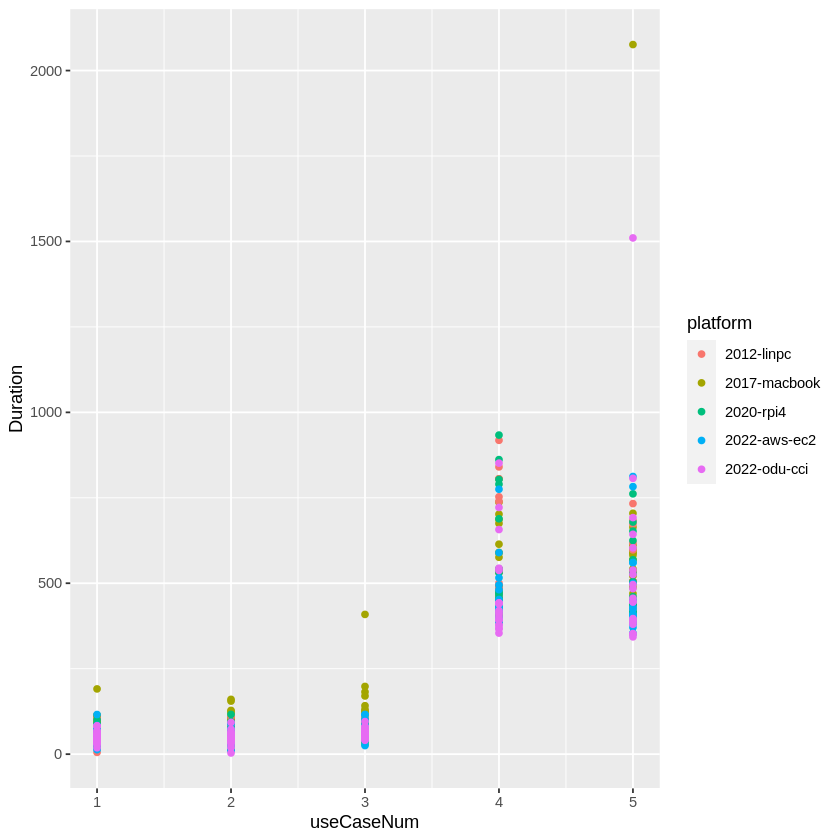

In [85]:
qplot(useCaseNum, Duration, data = spanMetricsA, colour = platform)

### Remove Macbook Data from Development Platform ###
Here we remove the data from the Macbook development platform. The qplot shows that the **Mac implementation of Docker** adds latency within the Docker environment. In non-linux based plaforms, a Docker desktop running a virtual machine is required to provided that Docker capability that is native to Linux platforms. The Mac is considered to be the development environment and not representative of the integration and production environments.

https://dev.to/ericnograles/why-is-docker-on-macos-so-much-worse-than-linux-flh  
https://collabnix.com/how-docker-for-mac-works-under-the-hood/  

In [86]:
noMacSpan <- spanMetricsA[!spanMetricsA$env == 0,]

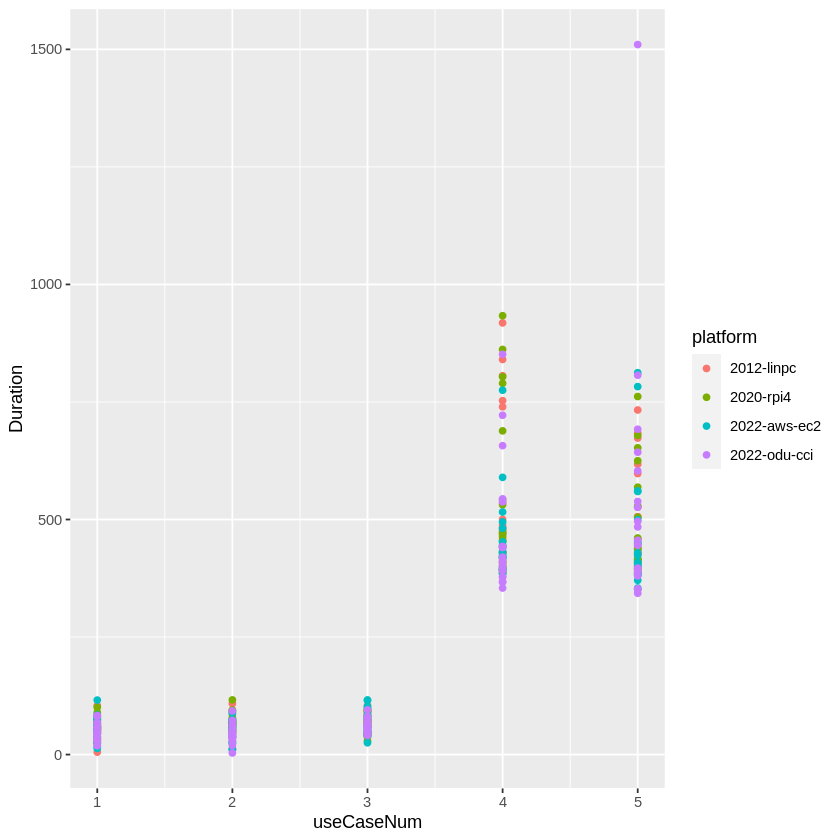

In [87]:
qplot(useCaseNum, Duration, data = noMacSpan, colour = platform)

In [88]:
# par(mfrow=c(2,1))
# hist(spanMetricsA$Duration, counts = 5)

# spanMetricsA %>%
#     ggplot(aes(Trace.name, Duration)) + 
#     stat_boxplot(notch="FALSE") + geom_point() +
#     ggtitle("Duration of Endpoint Responses from Trace")
# # notch went outside hinges. Try setting notch=FALSE.

In [89]:
# Remove outliers
aSpan <- noMacSpan
outliers <- boxplot(aSpan$Duration, plot = FALSE)$out
outliers

aSpan <- aSpan[-which(aSpan$Duration %in% outliers),]

[1] 1510.265

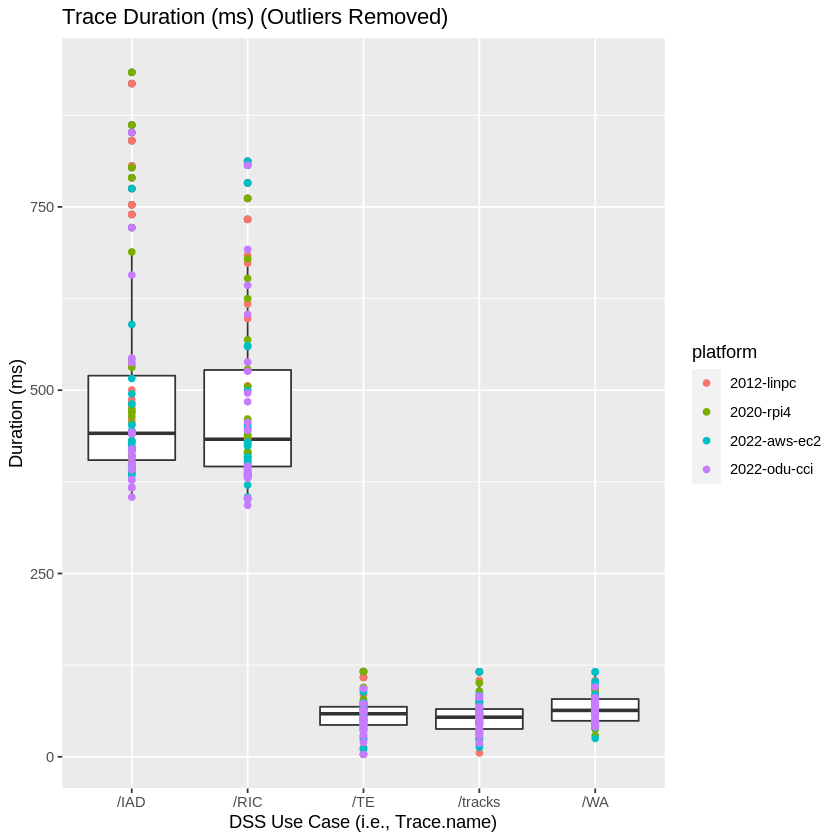

In [90]:
aSpan %>%
    ggplot(aes(Trace.name, Duration)) + 
    stat_boxplot(notch="FALSE") + geom_point(aes(colour = platform)) +
    ggtitle("Trace Duration (ms) (Outliers Removed)") +
    ylab("Duration (ms)") +
    xlab("DSS Use Case (i.e., Trace.name)")
# notch went outside hinges. Try setting notch=FALSE.

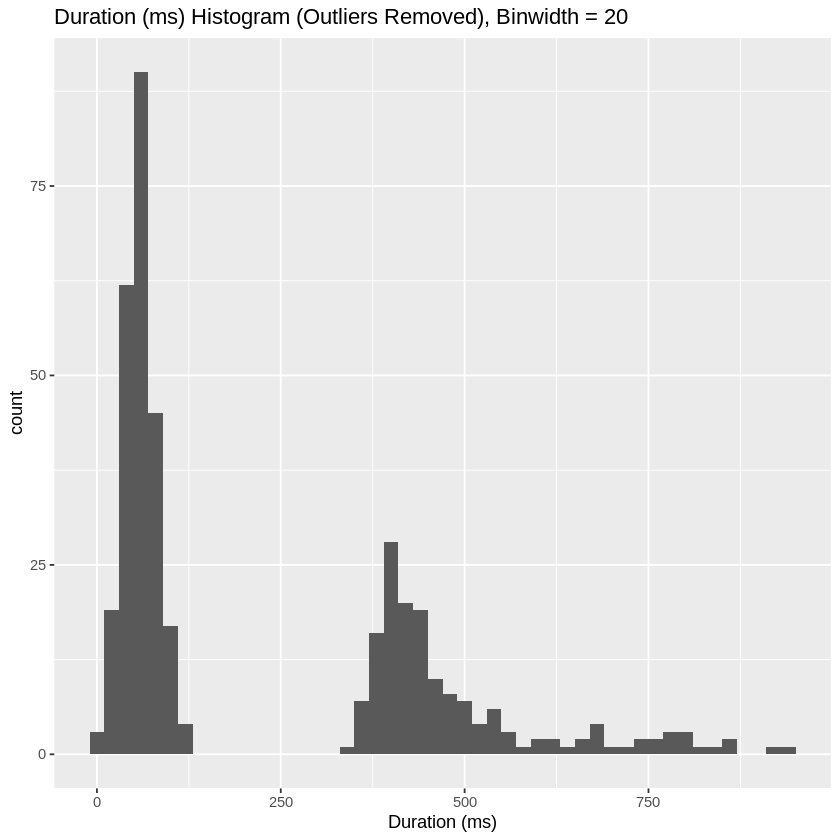

In [91]:
aSpan %>%
    ggplot(aes(Duration)) + geom_histogram(binwidth = 20) +
    ggtitle("Duration (ms) Histogram (Outliers Removed), Binwidth = 20") +
    xlab("Duration (ms)")

In [92]:
summary(aSpan)
sd(aSpan$Duration)

   Trace.ID          Trace.name         Start.time           Duration      
 Length:399         Length:399         Length:399         Min.   :  3.383  
 Class :character   Class :character   Class :character   1st Qu.: 53.790  
 Mode  :character   Mode  :character   Mode  :character   Median : 78.324  
                                                          Mean   :230.506  
                                                          3rd Qu.:417.031  
                                                          Max.   :933.505  
   platform              env          useCase            useCaseNum   
 Length:399         Min.   :1.000   Length:399         Min.   :1.000  
 Class :character   1st Qu.:1.500   Class :character   1st Qu.:2.000  
 Mode  :character   Median :2.000   Mode  :character   Median :3.000  
                    Mean   :2.496                      Mean   :2.995  
                    3rd Qu.:3.000                      3rd Qu.:4.000  
                    Max.   :4.000         

[1] 228.4005

In [93]:
# dnorm_aSpan <- aSpan
# dnorm_aSpan$Duration <- dnorm(dnorm_aSpan$Duration,mean=180.874,sd=229.4489)

# dnorm_aSpan %>%
#     ggplot(aes(Duration)) + geom_histogram() +
#     ggtitle("Duration (ms) Histogram (w dnorm, Binwidth = 20") +
#     xlab("Duration (ms)")

# shapiro.test(dnorm_aSpan$Duration)

In [94]:
# ggpairs(spanMetricsNum, title="correlogram with ggpairs()")

#### mclust ####

Used mclust to verify the separation of internal and external models as indicated from the useCaseNum vs. Duration plot; i.e. use cases 4 and 5 use an external API.

The library mclust is a contributed R package for model-based clustering, classification, and density estimation based on finite normal mixture modelling. It provides functions for parameter estimation via the EM algorithm for normal mixture models with a variety of covariance structures, and functions for simulation from these models.


_Scrucca L., Fop M., Murphy T. B. and Raftery A. E. (2016) mclust 5: clustering, classification and density estimation using Gaussian finite mixture models The R Journal 8/1, pp. 289-317_

In [95]:
install.packages("mclust")
library(mclust, quietly = TRUE)

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



#### Mclust Univariate Analysis of Duration ####

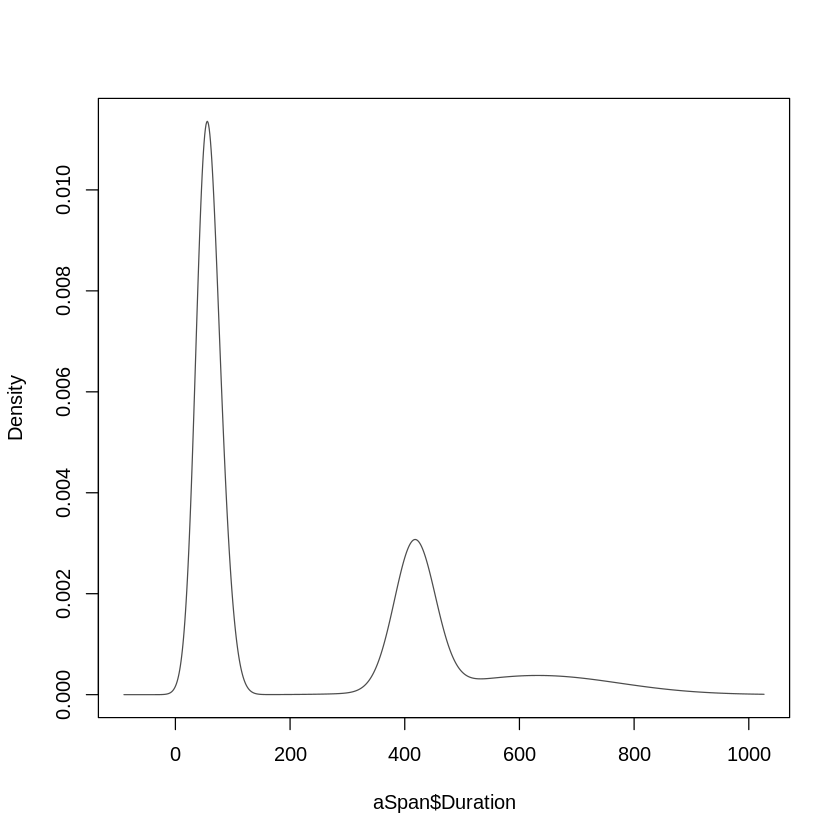

In [96]:
mod4 <- densityMclust(aSpan$Duration)

In [97]:
summary(mod4)

------------------------------------------------------- 
Density estimation via Gaussian finite mixture modeling 
------------------------------------------------------- 

Mclust V (univariate, unequal variance) model with 4 components: 

 log-likelihood   n df       BIC       ICL
      -2281.259 399 11 -4628.397 -4863.113

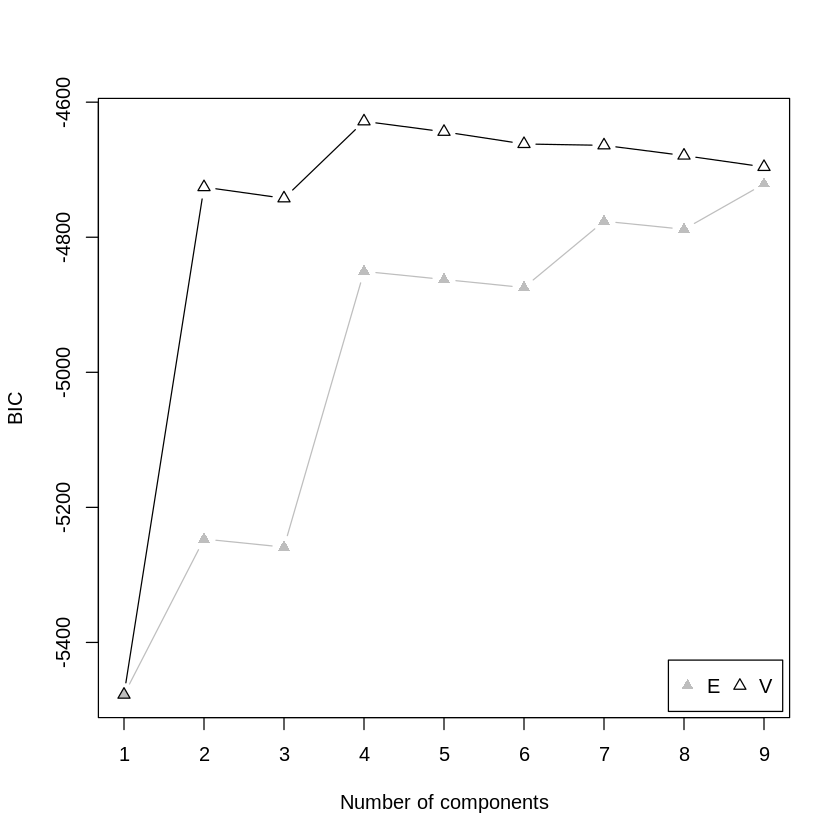

In [98]:
plot(mod4, what ="BIC")

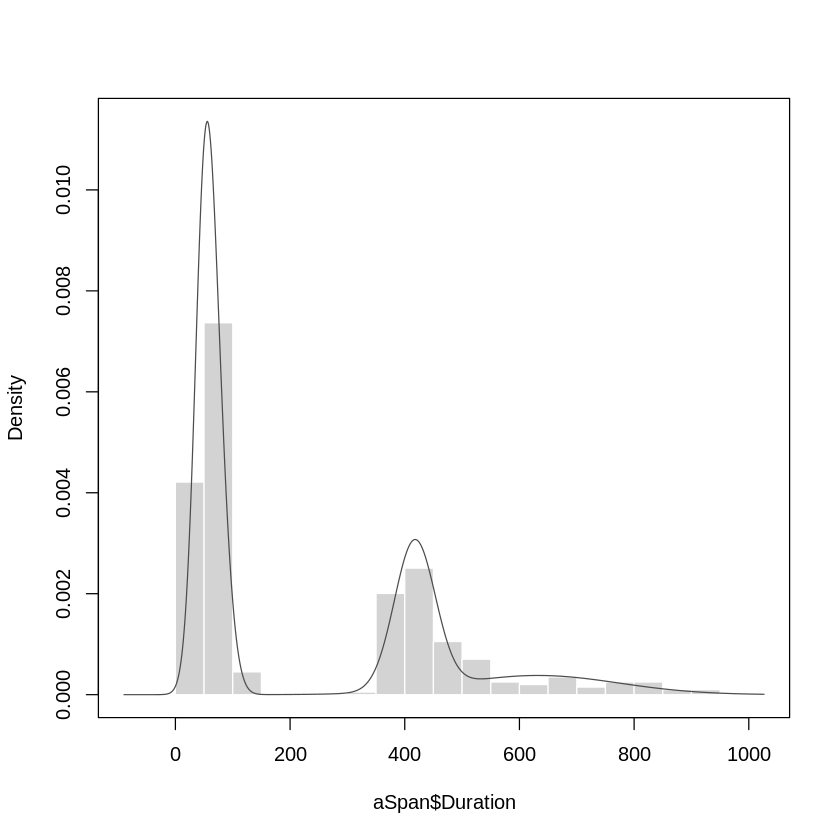

In [99]:
plot(mod4, what = "density", data = aSpan$Duration, breaks = 20)

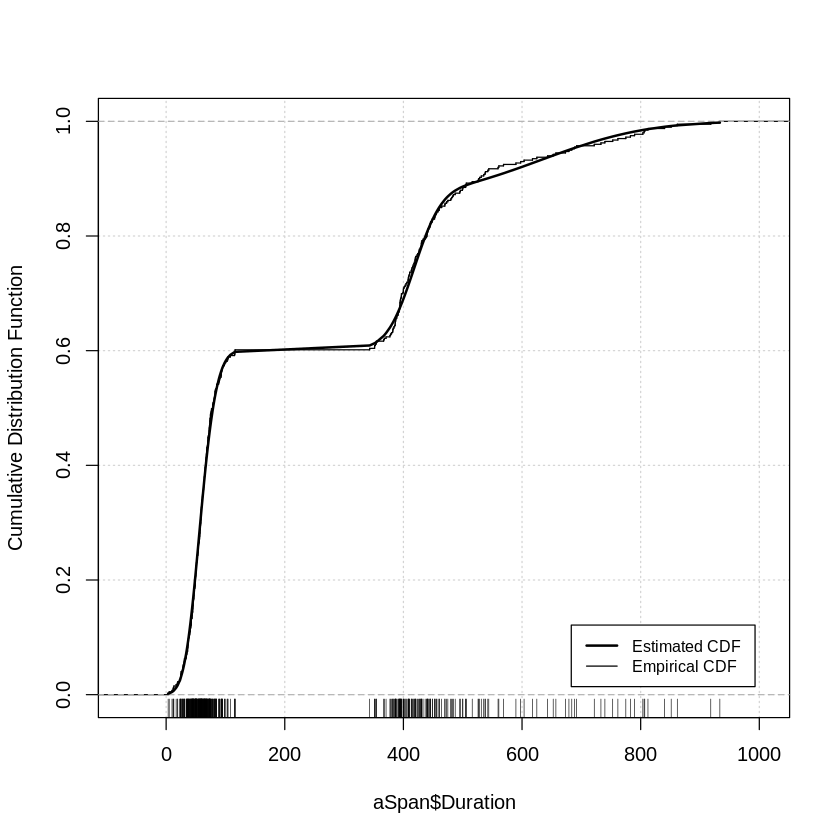

In [100]:
plot(mod4, what = "diagnostic", type = "cdf")

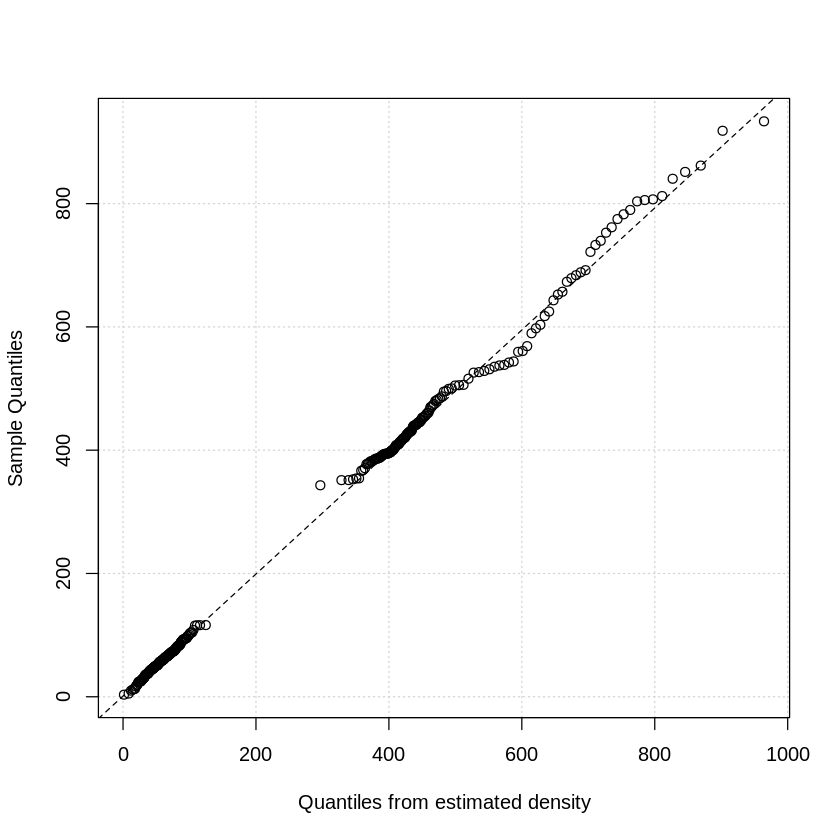

In [101]:
plot(mod4, what = "diagnostic", type = "qq")

#### Mclust Multivariate Analysis ####

,Duration,ext,env
,<dbl>,<lgl>,<dbl>
21,62.41822,FALSE,1
22,24.76708,FALSE,1
23,46.92540,FALSE,1
24,60.16123,FALSE,1
25,104.23387,FALSE,1
26,57.64300,FALSE,1


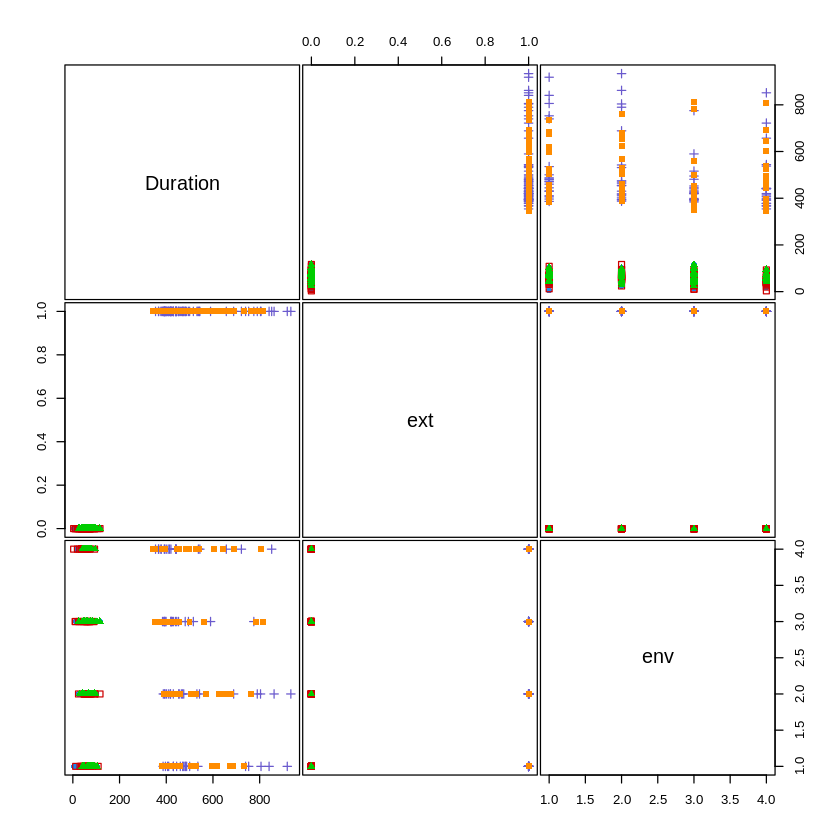

In [102]:
uc <- aSpan$useCaseNum # Trace.name is char, used uc num conversion

X <- aSpan %>%
    # dplyr::select(useCaseNum, env, ext, Duration)
    dplyr::select(Duration, ext, env)
    # dplyr::select(Duration)

head(X)
clPairs(X, uc)

In [103]:
# spanMclust <- Mclust(aSpan)
# spanMclust <- Mclust(X)
# summary(spanMclust)
# plot(spanMclust, what = c("classification"))

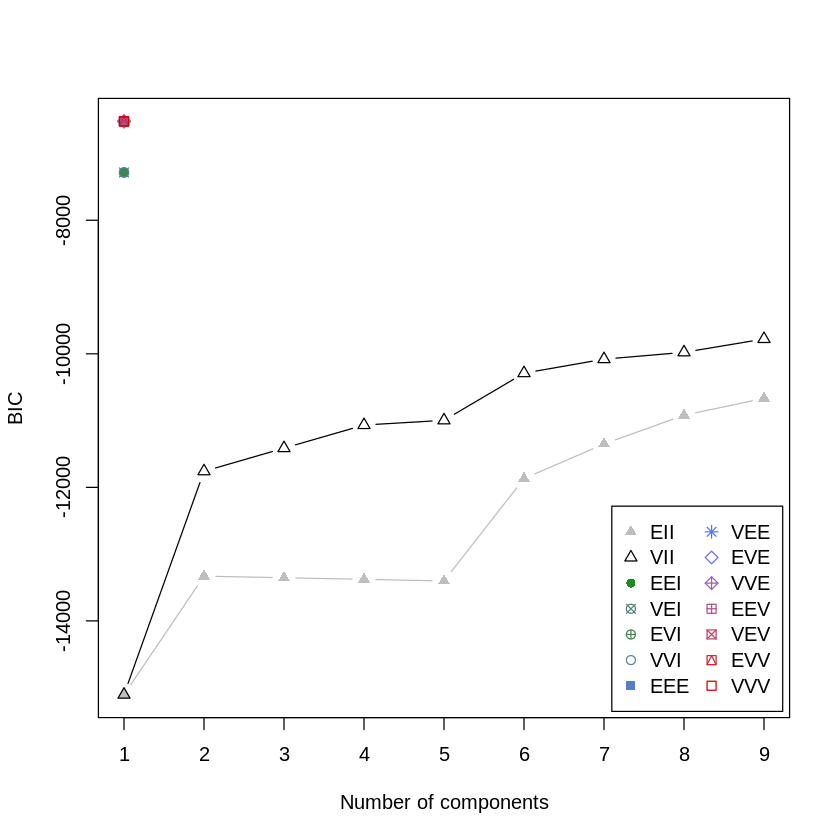

In [104]:
BIC <- mclustBIC(X)
plot(BIC)

In [105]:
summary(BIC)

Best BIC values:
             EEE,1     EEV,1     EVE,1
BIC      -6518.476 -6518.476 -6518.476
BIC diff     0.000     0.000     0.000

Note that 2 is included within the list of best Bayesian Information Criterion (BIC) values.

In [106]:
# mod1 <- Mclust(X, x = BIC)
# summary(mod1, parameters = TRUE)

In [107]:
# plot(mod1, what = "classification")

In [108]:
# plot(mod1, what = "uncertainty")

In [109]:
# ICL <- mclustICL(X)
# summary(ICL)
# plot(ICL)

In [110]:
# LRT <- mclustBootstrapLRT(X, modelName = "VEV")
# LRT

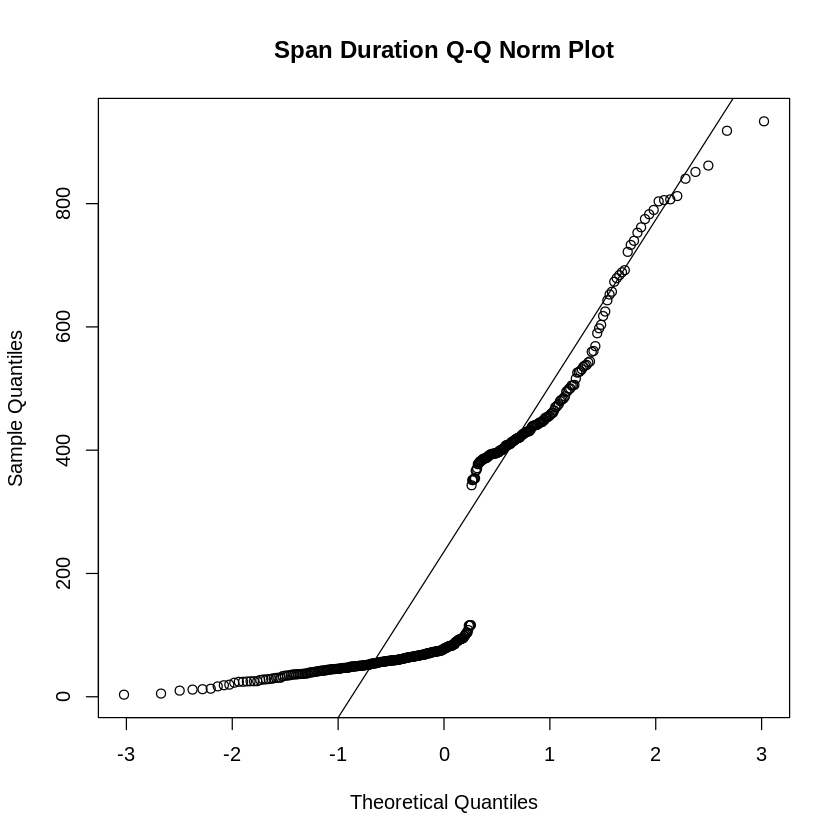

In [111]:
qqnorm(aSpan$Duration, main="Span Duration Q-Q Norm Plot")
qqline(aSpan$Duration)

In [112]:
# head(aSpan)

In [113]:
aSpan_Density <- aSpan %>%
    # dplyr::select(useCaseNum, env, ext, Duration)
    dplyr::select(ext, Duration)
    # dplyr::select(Duration)

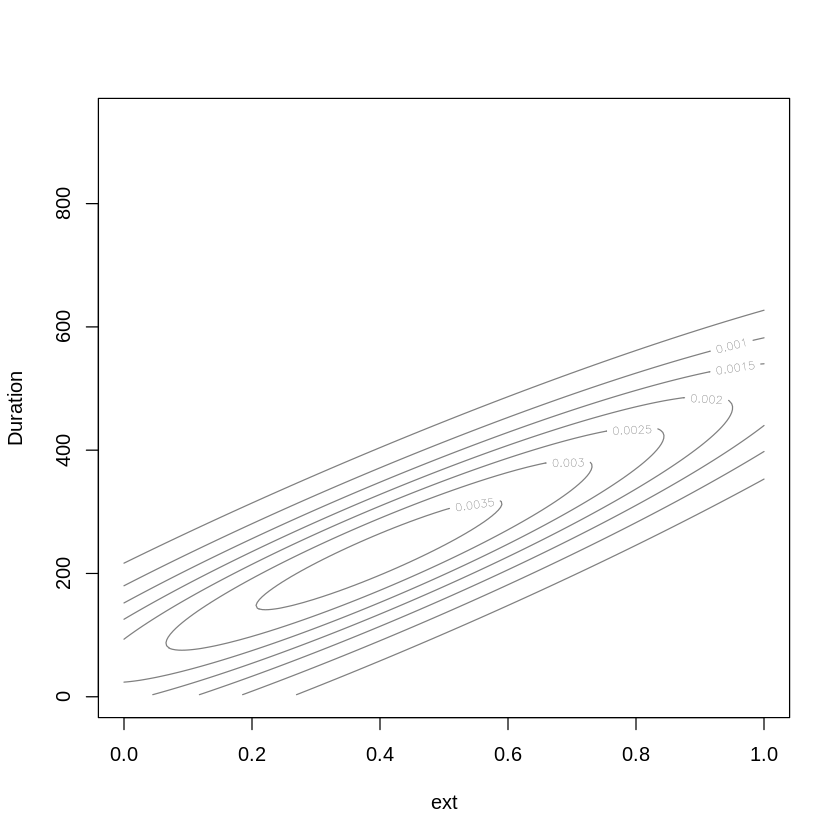

In [114]:
mod5 <- densityMclust(aSpan_Density)

## Separating Internal from External Data ##

### Internal Data ###

In [141]:
# Separate Internal Data
# Could use ext == FALSE

tracksSpanData = subset(aSpan, useCaseNum == 1)
TE_SpanData = subset(aSpan, useCaseNum == 2)
WA_SpanData = subset(aSpan, useCaseNum == 3)

internalSpanData <- rbind(tracksSpanData, TE_SpanData, WA_SpanData)
dssSpanData <- rbind(TE_SpanData, WA_SpanData)

In [142]:
# Remove Outliers
# outliers <- boxplot(internalSpanData$Duration, plot = FALSE)$out
# outliers
# iSpan <- iSpan[-which(iSpan$Duration %in% outliers),]

# outliers <- which(internalSpanData$Duration > 50) #outlier rows
# outliers
# iSpan <- internalSpanData[!outliers,]
# iSpan <- dssSpanData[!dssSpanData$Duration > 50,]
# iSpan <- internalSpanData[!internalSpanData$Duration > 50,]
    # Remove if duration is greater than a value

iSpan <- internalSpanData

In [143]:
summary(iSpan)
sd(iSpan$Duration)

   Trace.ID          Trace.name         Start.time           Duration      
 Length:240         Length:240         Length:240         Min.   :  3.383  
 Class :character   Class :character   Class :character   1st Qu.: 44.872  
 Mode  :character   Mode  :character   Mode  :character   Median : 58.213  
                                                          Mean   : 58.531  
                                                          3rd Qu.: 71.177  
                                                          Max.   :116.297  
   platform              env         useCase            useCaseNum
 Length:240         Min.   :1.00   Length:240         Min.   :1   
 Class :character   1st Qu.:1.75   Class :character   1st Qu.:1   
 Mode  :character   Median :2.50   Mode  :character   Median :2   
                    Mean   :2.50                      Mean   :2   
                    3rd Qu.:3.25                      3rd Qu.:3   
                    Max.   :4.00                      Max.   :3   

[1] 21.50083

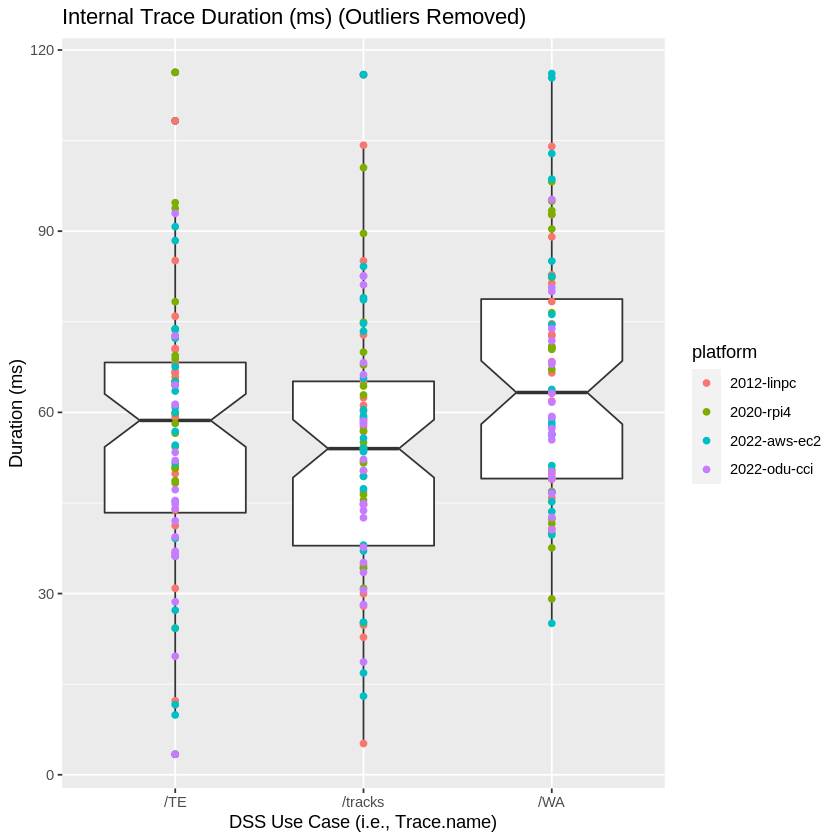

In [144]:
iSpan %>%
    ggplot(aes(Trace.name, Duration)) + 
    stat_boxplot(notch="TRUE") + geom_point(aes(colour = platform)) +
    ggtitle("Internal Trace Duration (ms) (Outliers Removed)") +
    ylab("Duration (ms)") +
    xlab("DSS Use Case (i.e., Trace.name)")

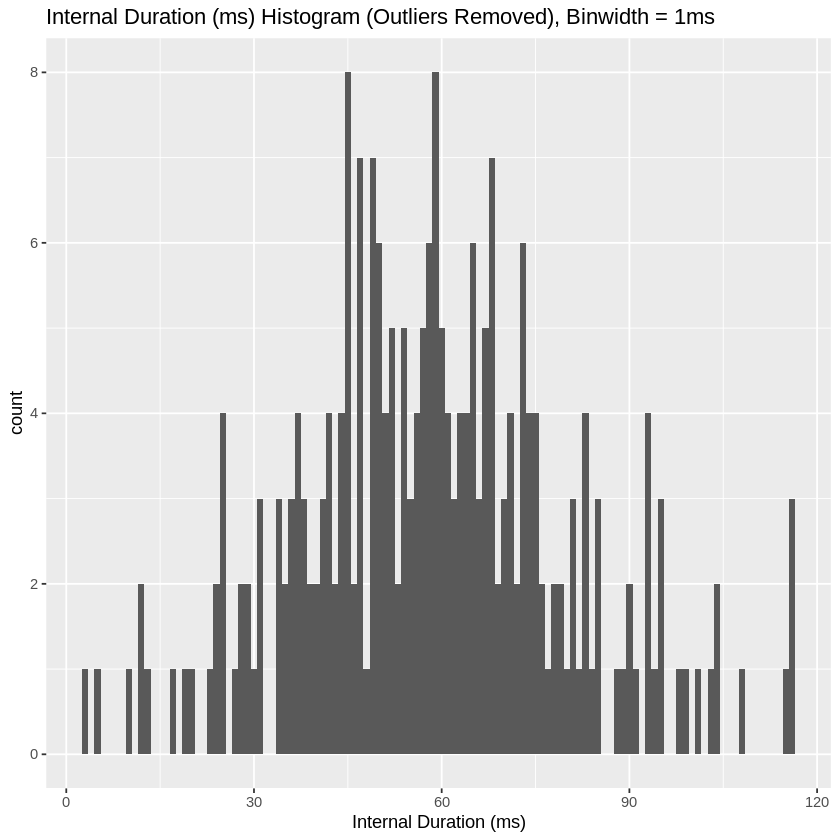

In [145]:
iSpan %>%
    ggplot(aes(Duration)) + geom_histogram(binwidth = 1) +
    ggtitle("Internal Duration (ms) Histogram (Outliers Removed), Binwidth = 1ms") +
    xlab("Internal Duration (ms)")

In [146]:
# dnorm_iSpan <- iSpan
# dnorm_iSpan$Duration <- dnorm(dnorm_iSpan$Duration,mean=7.745,sd=2.776)

# dnorm_iSpan %>%
#     ggplot(aes(Duration)) + geom_histogram() +
#     ggtitle("Duration (ms) Histogram (w dnorm, Binwidth = auto") +
#     xlab("Duration (ms)")

# shapiro.test(dnorm_iSpan$Duration)

Note that the histogram plot indicates that the data is not normally distrbuted and will need a transformation to enable application of statistics.

### External Data ###

In [147]:
RIC_SpanData = subset(aSpan, useCaseNum == 5)
IAD_SpanData = subset(aSpan, useCaseNum == 4)

externalSpanData <- rbind(RIC_SpanData, IAD_SpanData)

In [148]:
# Remove outliers
# outliers <- boxplot(externalSpanData$Duration, plot = FALSE)$out
# outliers

eSpan <- externalSpanData
# eSpan <- eSpan[-which(eSpan$Duration %in% outliers),]

In [149]:
summary(eSpan)
sd(eSpan$Duration)

   Trace.ID          Trace.name         Start.time           Duration    
 Length:159         Length:159         Length:159         Min.   :343.1  
 Class :character   Class :character   Class :character   1st Qu.:399.6  
 Mode  :character   Mode  :character   Mode  :character   Median :439.7  
                                                          Mean   :490.1  
                                                          3rd Qu.:527.6  
                                                          Max.   :933.5  
   platform              env          useCase            useCaseNum   
 Length:159         Min.   :1.000   Length:159         Min.   :4.000  
 Class :character   1st Qu.:1.500   Class :character   1st Qu.:4.000  
 Mode  :character   Median :2.000   Mode  :character   Median :4.000  
                    Mean   :2.491                      Mean   :4.497  
                    3rd Qu.:3.000                      3rd Qu.:5.000  
                    Max.   :4.000                      M

[1] 134.0636

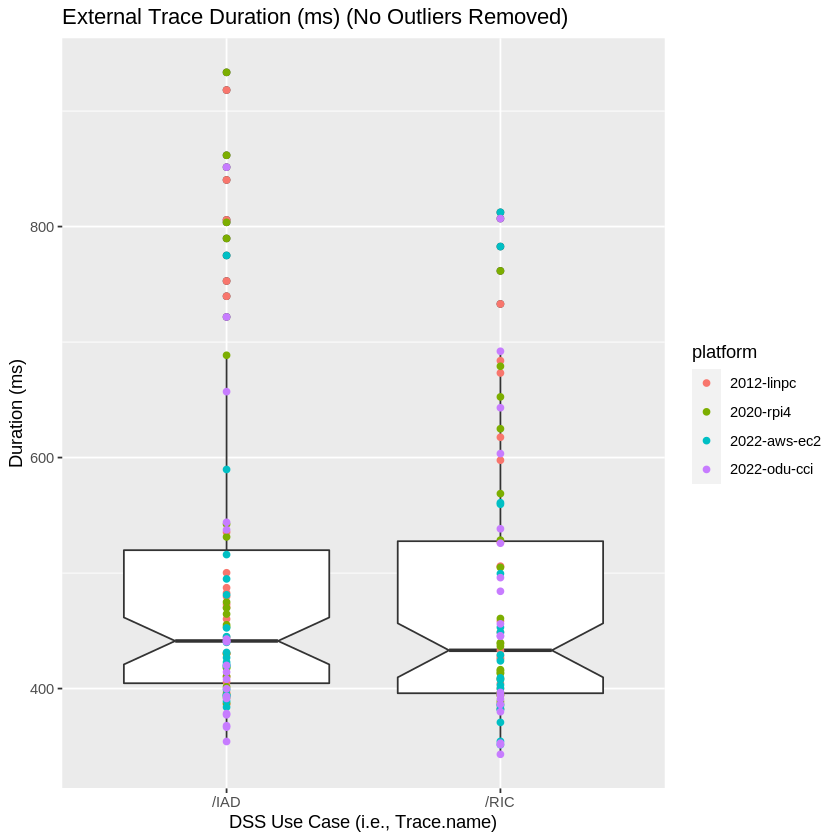

In [150]:
eSpan %>%
    ggplot(aes(Trace.name, Duration)) + 
    stat_boxplot(notch="TRUE") + geom_point(aes(colour = platform)) +
    ggtitle("External Trace Duration (ms) (No Outliers Removed)") +
    ylab("Duration (ms)") +
    xlab("DSS Use Case (i.e., Trace.name)")

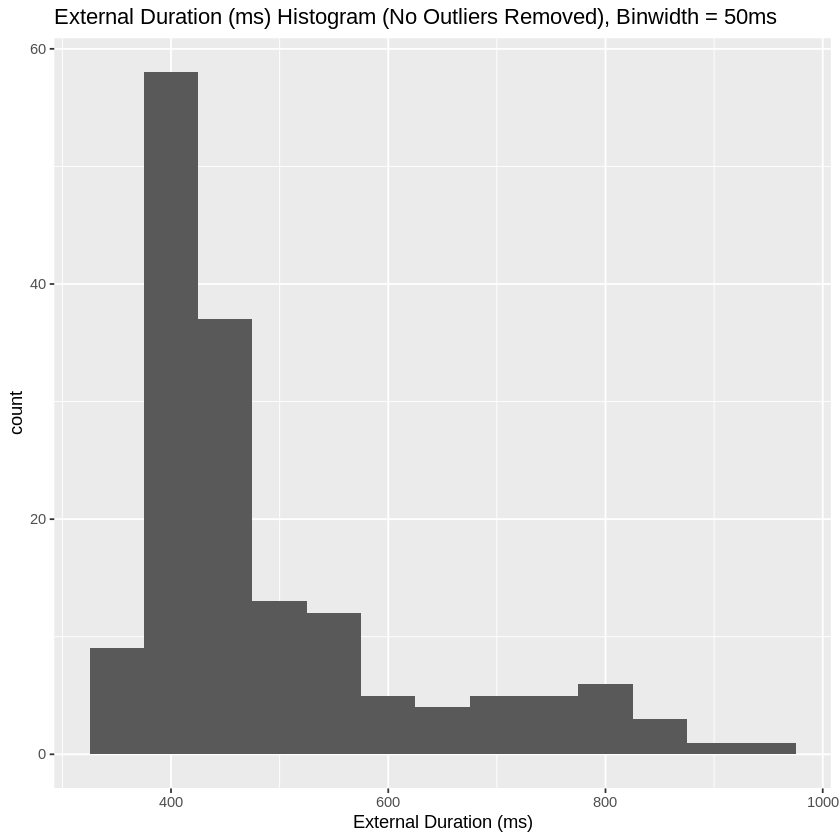

In [151]:
eSpan %>%
    ggplot(aes(Duration)) + geom_histogram(binwidth = 50) +
    ggtitle("External Duration (ms) Histogram (No Outliers Removed), Binwidth = 50ms") +
    xlab("External Duration (ms)")

Note that the histogram plot of the external data indicates that the data is not normally distributed and will need a transformation to enable application of statistics.

## Transformation and Normality Testing of the Data ##

The histograms of the internal and external span data imply that a log transform is needed; however, we need to look at cube and sqrt transforms.  A Box-Cox transformation may also need to be explored. Once that data has been transformed, we shall use a Shapiro-Wilk test to assess whether or not the data is normally distributed.

### Box-Cox Transformation ###

Box and Cox (1964) developed a family of transformations designed to reduce nonnormality of the errors in a linear model. Applying this transform often reduces non-linearity as well, and heteroscedascity.

The idea is to transform the response variable $Y$ to a replacement response variable $Y_i^{(\lambda)}$, leaving the right-hand side of the regression model unchanged, so that the regression residuals become normally-distributed. Note that the regression coefficients will also change, because the response variable has changed; therefore, the regression coefficients must be interpreted with respect to the transformed variable. Also, any predictions made with the model have to be back-transformed, to be interpreted in the original units.

The standard (simple) Box-Cox transform is:

$$
    Y_i^{(\lambda)}=
\begin{cases}
{\frac {Y_i^\lambda - 1} \lambda},  & {(\lambda \neq 0)} \\
log(Y_i), & {(\lambda = 0)}
\end{cases}
$$

_Box, G. E. P., & Cox, D. R. (1964). An Analysis of Transformations. Journal of the Royal Statistical Society, Series B (Metholodogical), 26(2), 211-252._

http://www.css.cornell.edu/faculty/dgr2/_static/files/R_html/Transformations.html

### Shapiro-Wilk Test ###

The null-hypothesis of this test is that the population is normally distributed. Thus, if the p value is less than the chosen alpha level, then the null hypothesis is rejected and there is evidence that the data tested are not normally distributed. On the other hand, if the p value is greater than the chosen alpha level, then the null hypothesis (that the data came from a normally distributed population) can not be rejected (e.g., for an alpha level of .05, a data set with a p value of less than .05 rejects the null hypothesis that the data are from a normally distributed population).

https://en.wikipedia.org/wiki/Shapiro–Wilk_test

### Data Transformations and Hypothesis Testing (Internal Data) ###

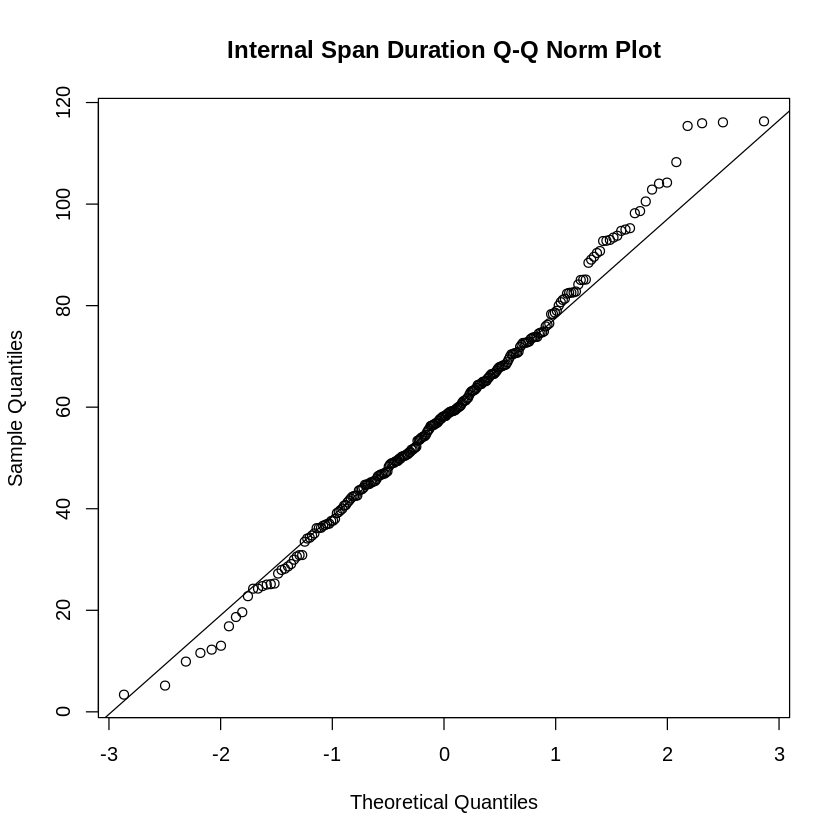

In [152]:
qqnorm(iSpan$Duration, main="Internal Span Duration Q-Q Norm Plot")
qqline(iSpan$Duration)

#### Sqrt-Log-Cube Transformations ####

Warning message in plot.window(xlim, ylim, "", ...):
“"counts" is not a graphical parameter”
Warning message in title(main = main, sub = sub, xlab = xlab, ylab = ylab, ...):
“"counts" is not a graphical parameter”
Warning message in axis(1, ...):
“"counts" is not a graphical parameter”
Warning message in axis(2, ...):
“"counts" is not a graphical parameter”


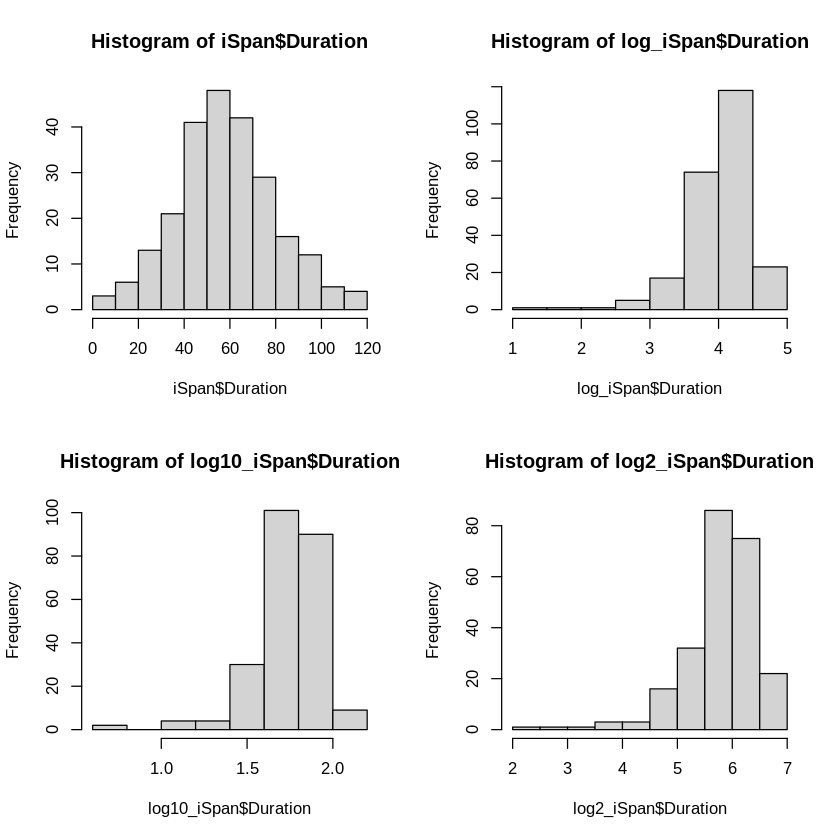

In [153]:
# sqrt_iSpan <- iSpan
# sqrt_iSpan$Duration=sqrt(sqrt_iSpan$Duration)

# log_iSpan <- iSpan
# log_iSpan$Duration=log(log_iSpan$Duration + 1) # Natural Log
# log10_iSpan <- iSpan
# log10_iSpan$Duration=log10(log10_iSpan$Duration + 1) # Log Base 10
# log2_iSpan <- iSpan
# log2_iSpan$Duration=log2(log2_iSpan$Duration + 1) # Log Base 2

# cube_iSpan <- iSpan
# cube_iSpan$Duration=cube_iSpan$Duration^(1/3)

# par(mfrow=c(2,2))
# hist(iSpan$Duration, counts = 10)
# hist(log_iSpan$Duration)
# hist(log10_iSpan$Duration)
# hist(log2_iSpan$Duration)

#### Box-Cox Transformation ####

In [154]:
library("MASS")

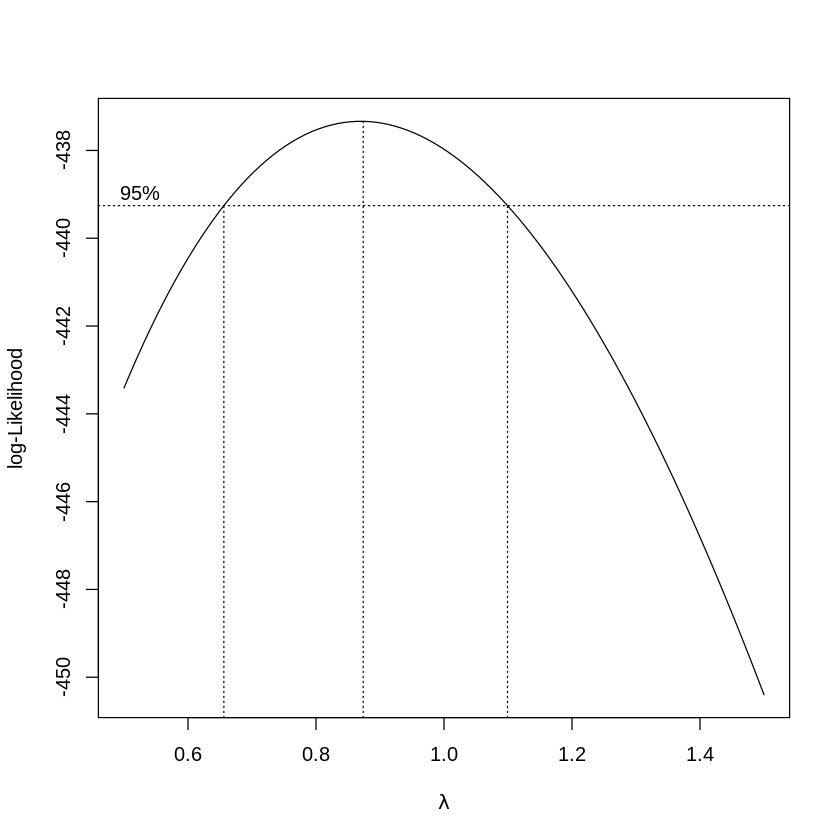

In [168]:
bc_iSpan = iSpan
x <- bc_iSpan$Duration
bc = boxcox(lm(x ~ 1), seq(0.5,1.5,.1))
# bc = boxcox(lm(x ~ bcData$useCaseNum))
lambda <- bc$x[which.max(bc$y)]
new_x_exact <- (x ^ lambda - 1) / lambda

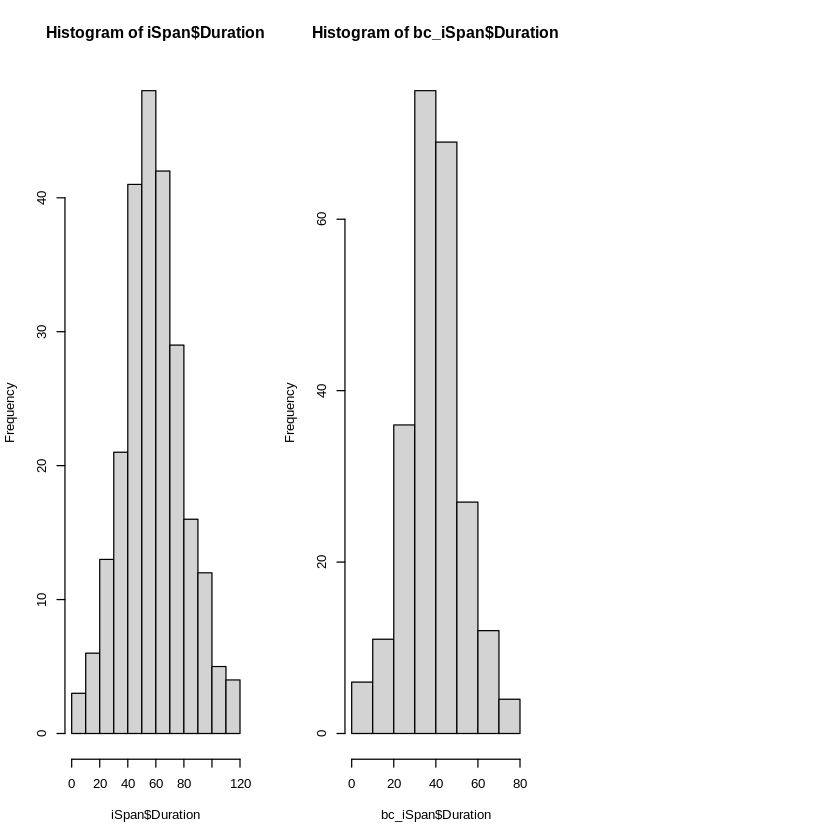

In [156]:
bc_iSpan$Duration = new_x_exact
par(mfrow=c(1,3))
hist(iSpan$Duration)
hist(bc_iSpan$Duration)

#### Shapiro-Wilk Normality Test ####

In [169]:
shapiro.test(iSpan$Duration)

# shapiro.test(log_iSpan$Duration)
# shapiro.test(log10_iSpan$Duration)
# shapiro.test(log2_iSpan$Duration)

# shapiro.test(sqrt_iSpan$Duration)
# shapiro.test(cube_iSpan$Duration)

shapiro.test(bc_iSpan$Duration)


	Shapiro-Wilk normality test

data:  iSpan$Duration
W = 0.99298, p-value = 0.3162



	Shapiro-Wilk normality test

data:  bc_iSpan$Duration
W = 0.99298, p-value = 0.3162


With all p-values > 0.05 we fail to reject the null hypothesis and assume we have a normal distribution.

_"if the p value is greater than the chosen alpha level, then the null hypothesis (that the data came from a normally distributed population) can not be rejected"_

#### Hypothesis Testing (Need to Correct Issue) ####

We will use a Student's t-Test to test the hypothesis on **normal** internal span data. Our mean is 500 ms (e.g. $\mu = 0.5$ seconds) and our null hypthesis is less than 500 ms.

In [159]:
mu = 0.5
x = cube_iSpan$Duration
cube_mu = mu^(1/3)
t.test(x=x, mu=cube_mu, alternative = 'greater')


	One Sample t-test

data:  x
t = 87.894, df = 239, p-value < 2.2e-16
alternative hypothesis: true mean is greater than 0.7937005
95 percent confidence interval:
 3.756558      Inf
sample estimates:
mean of x 
 3.813286 


With a p-value of ___ > 0.05 we reject the null hypothesis, i.e. we assume that latency will be greater than 500 ms.

_"If the p value is greater than the chosen alpha level, then the null hypothesis (that latency is < 500 ms) can not be rejected"_

### Data Transformations and Hypothesis Testing (External Data) ###

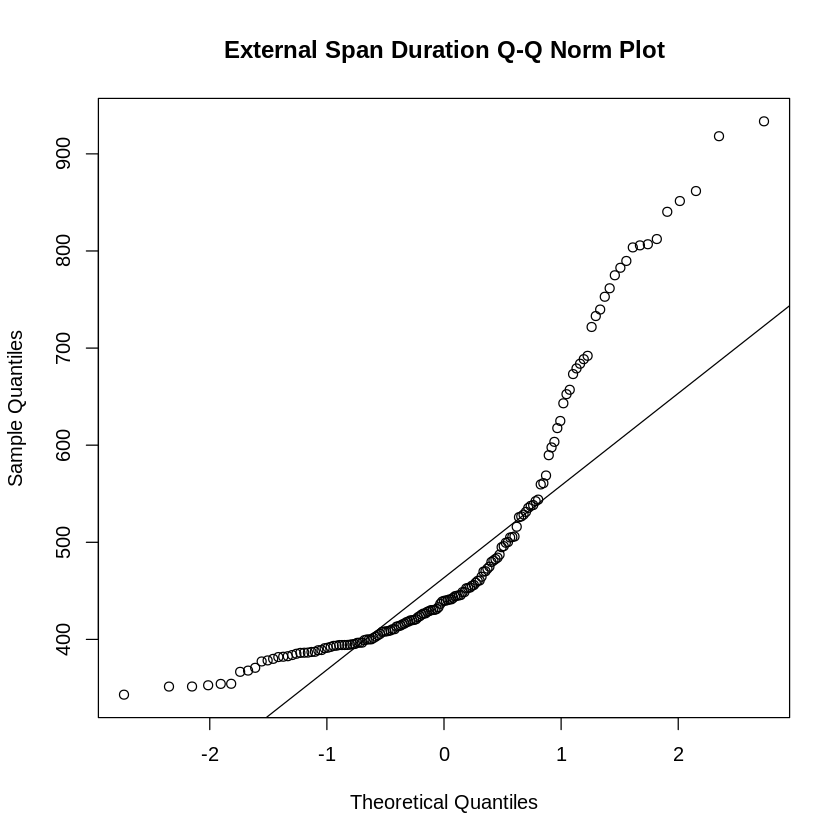

In [160]:
qqnorm(eSpan$Duration, main="External Span Duration Q-Q Norm Plot")
qqline(eSpan$Duration)

#### Sqrt-Log-Cube Transformations ####

Warning message in plot.window(xlim, ylim, "", ...):
“"counts" is not a graphical parameter”
Warning message in title(main = main, sub = sub, xlab = xlab, ylab = ylab, ...):
“"counts" is not a graphical parameter”
Warning message in axis(1, ...):
“"counts" is not a graphical parameter”
Warning message in axis(2, ...):
“"counts" is not a graphical parameter”


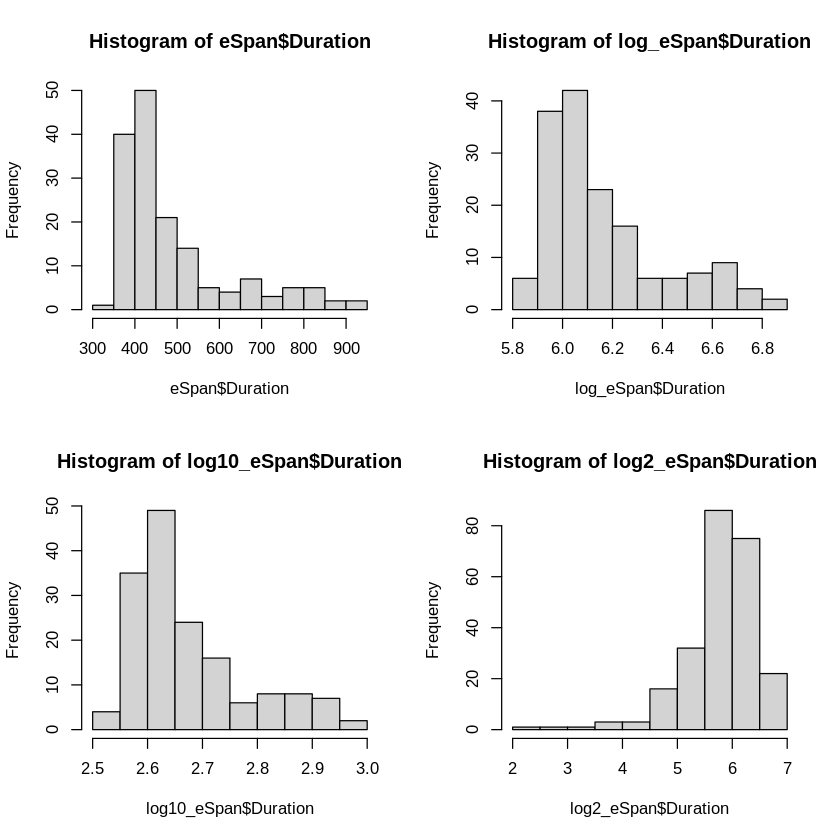

In [161]:
sqrt_eSpan <- eSpan
sqrt_eSpan$Duration=sqrt(sqrt_eSpan$Duration)

log_eSpan <- eSpan
log_eSpan$Duration=log(log_eSpan$Duration + 1) # Natural Log
log10_eSpan <- eSpan
log10_eSpan$Duration=log10(log10_eSpan$Duration + 1) # Log Base 10
log2_eSpan <- iSpan
log2_eSpan$Duration=log2(log2_eSpan$Duration + 1) # Log Base 2

cube_eSpan <- eSpan
cube_eSpan$Duration=cube_eSpan$Duration^(1/3)

par(mfrow=c(2,2))
hist(eSpan$Duration, counts = 50)
hist(log_eSpan$Duration)
hist(log10_eSpan$Duration)
hist(log2_eSpan$Duration)

#### Box-Cox Transformation ####

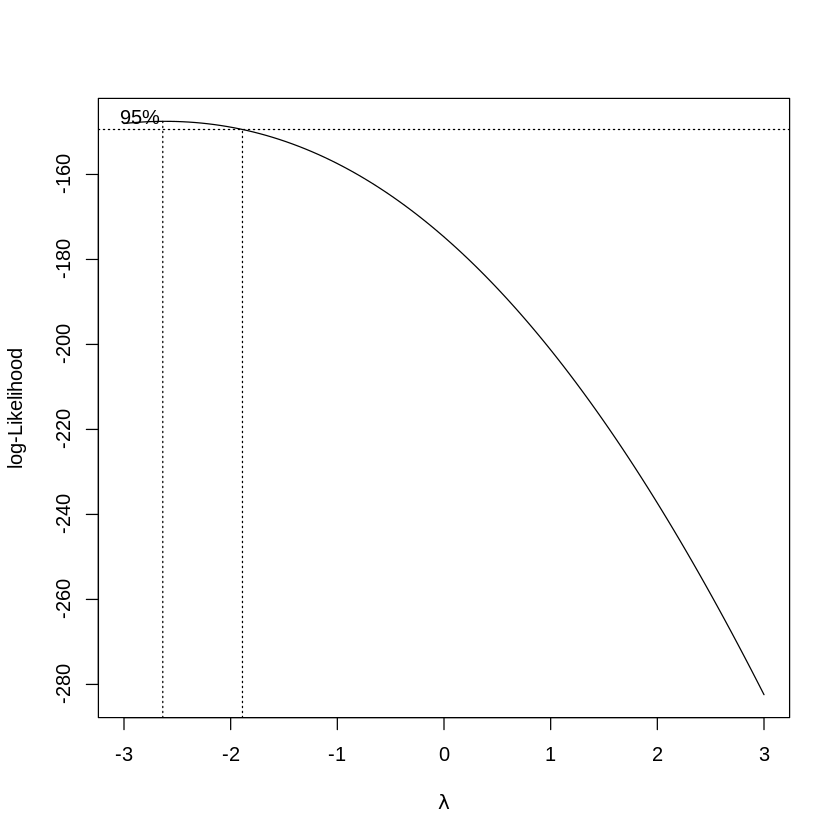

In [162]:
bc_eSpan = eSpan
x <- bc_eSpan$Duration
bc = boxcox(lm(x ~ 1), seq(-3,3,.1))
# bc = boxcox(lm(x ~ bcData$useCaseNum))
lambda <- bc$x[which.max(bc$y)]
new_x_exact <- (x ^ lambda - 1) / lambda

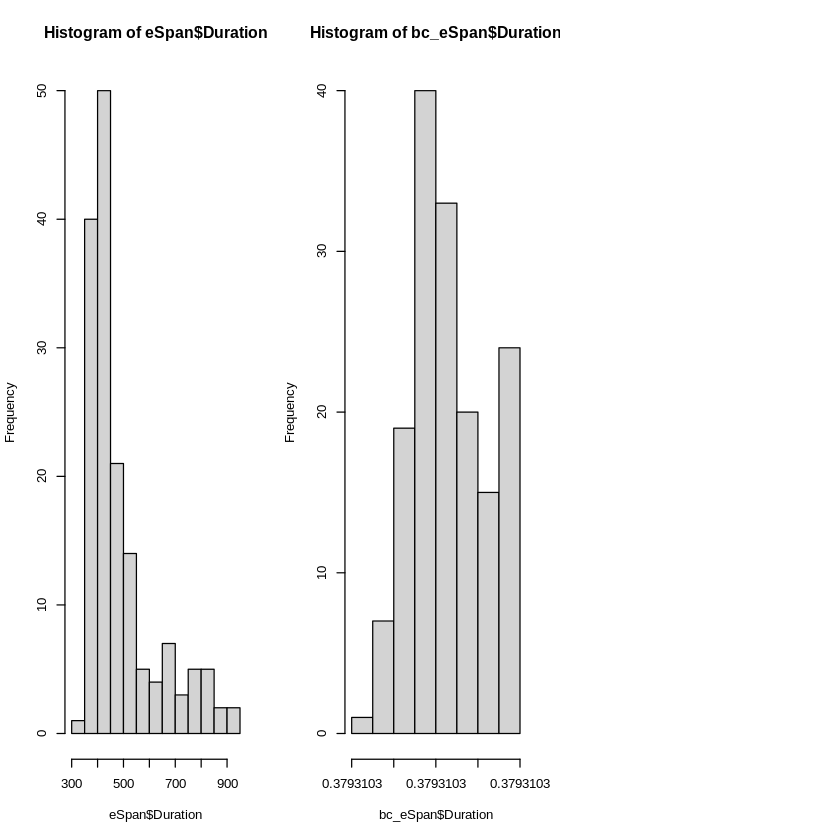

In [163]:
bc_eSpan$Duration = new_x_exact
par(mfrow=c(1,3))
hist(eSpan$Duration)
hist(bc_eSpan$Duration)

#### Shapiro-Wilk Normality Test ####

In [164]:
shapiro.test(eSpan$Duration)

shapiro.test(log_eSpan$Duration)
shapiro.test(log10_eSpan$Duration)
shapiro.test(log2_eSpan$Duration)

shapiro.test(sqrt_eSpan$Duration)
shapiro.test(cube_eSpan$Duration)

shapiro.test(bc_eSpan$Duration)


	Shapiro-Wilk normality test

data:  eSpan$Duration
W = 0.79592, p-value = 1.275e-13



	Shapiro-Wilk normality test

data:  log_eSpan$Duration
W = 0.86315, p-value = 7.391e-11



	Shapiro-Wilk normality test

data:  log10_eSpan$Duration
W = 0.86315, p-value = 7.391e-11



	Shapiro-Wilk normality test

data:  log2_eSpan$Duration
W = 0.87854, p-value = 6.385e-13



	Shapiro-Wilk normality test

data:  sqrt_eSpan$Duration
W = 0.83093, p-value = 2.823e-12



	Shapiro-Wilk normality test

data:  cube_eSpan$Duration
W = 0.84205, p-value = 8.276e-12



	Shapiro-Wilk normality test

data:  bc_eSpan$Duration
W = 0.96388, p-value = 0.000364


With a p-value of _____ < 0.05 we reject the null hypothesis, i.e. we assume that we do not have a normal distribution.

_"if the p value is greater than the chosen alpha level, then the null hypothesis (that the data came from a normally distributed population) can not be rejected"_

#### Hypothesis Testing (Update and Correct) ####

We will use a Student's t-Test to test the hypothesis on external span data. Our mean is 500 ms (e.g. $\mu = 0.5$ seconds) and our null hypthesis is less than 500 ms.

In [165]:
mu = 0.5

In [166]:
x = eSpan$Duration
t.test(x=x, mu=mu, alternative = 'greater')


	One Sample t-test

data:  x
t = 46.049, df = 158, p-value < 2.2e-16
alternative hypothesis: true mean is greater than 0.5
95 percent confidence interval:
 472.4992      Inf
sample estimates:
mean of x 
 490.0903 


With a p-value of _____ > 0.05 we fail to reject the null hypothesis, i.e. we assume that 500 ms can be maintained for external service requests.

_"If the p value is greater than the chosen alpha level, then the null hypothesis (that latency is < 500 ms) can not be rejected"_

## Observations ##

### General Discussion of Normality ###
It was required to separate external data from internal to establish normality of the data samples. The internal data set required transformation to establish normality, while the external data did not require a transformation. 

### Hypothesis Results (Update to Reflect Results) ###

Hypothesis testing using the Student's t-Test indicates that latency constraints of 500 ms can be maintained internally and external. However, serveral external samples were greater than 500 ms. This is most likely due to the non-deterministic nature of internet (e.g. http) requests. Within the internal environment, data is directly routed between microservices within the Docker environment within a private network. The data shows that a container based microservice architecture can meet the requirement; however, care must be taken to manage processing per container that may increase container response times.

### DSS Prototype Environment ###

The non deterministic nature of the Docker environment on the MacBook laptop significantly affected the ability to assess deterministic behavior. Boxplots of data inclusive of what was sampled from the MacBook clearly depicted this issue. Linux platforms truly run a container as intended; however, non-linux platform require the use of a Linux based Virtual Machine on top of the host OS to implement containers. While the MacBook met the needs for rapid software development, the use of a separate integration and test environment was clearly validated through the collected data.